In [37]:
import question_server as qs

In [30]:
response = qs.ask_question(45,"AND")
headers = list(response.columns)
values = list(response.iloc[0])
values


Connection to PostgreSQL DB successful
AND


['45.0',
 'Future changes',
 'Greater respect for authority',
 '0.5%',
 '47.01%',
 '44.32%',
 '8.17%',
 1004]

In [40]:

qs.ask_question(46,"IRQ")

Connection to PostgreSQL DB successful
IRQ


,Question,Theme,Subtheme,Don't know,No answer,Very happy,Quite happy,Not very happy,Not at all happy,Answers
0,46.0,Feeling of happiness,0,0.58%,1.17%,17.92%,51.25%,19.33%,9.75%,1200


In [42]:
import question_server as qs2
qs2.ask_question(32,"IRQ")

Connection to PostgreSQL DB successful
IRQ


,Question,Theme,Subtheme,Don't know,No answer,Agree strongly,Agree,Disagree,Strongly disagree,Answers
0,32.0,Being a housewife just as fulfilling,0,2.5%,0.83%,45.92%,24.67%,18.25%,7.83%,1200


In [48]:
qs.ask_question(42,"AND")

Connection to PostgreSQL DB successful
AND


,Question,Theme,Subtheme,No answer,The entire way our society is organized must be radically changed by revolutionary action,Our society must be gradually improved by reforms,Our present society must be valiantly defended against all subversive forces,Answers
0,42.0,Basic kinds of attitudes concerning society,0,4.18%,11.25%,81.47%,3.09%,1004


In [54]:
import question_server
question_server.ask_question(4,"IRQ")

Connection to PostgreSQL DB successful
IRQ


,Question,Theme,Subtheme,Don't know,No answer,Very important,Rather important,Not very important,Not at all important,Answers
0,4.0,Important in life,Politics,2.08%,0.42%,17.58%,21.42%,27.75%,30.75%,1200


In [137]:
#import question_server as qs
from flask import Flask
from flask_cors import CORS
from flask import request
import pandas as pd
import psycopg2
from psycopg2 import OperationalError

from multiprocessing import connection
import json

def create_connection(db_name, db_user, db_password, db_host, db_port):
    connection = None
    try:
        connection = psycopg2.connect(
            database=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port,
        )
        
        print("Connection to PostgreSQL DB successful")
    except OperationalError as e:
        print(f"The error '{e}' occurred")
    return connection

def question_setup():
    global connection
    connection = create_connection(
        "country_app", "postgres", "", "127.0.0.1", "5432"
    )
    return connection



In [128]:

question_nr, country_alpha = 29, 'IRQ'

select_question_answers = f"""
    SELECT "Q{question_nr}", COUNT("Q{question_nr}") FROM QUESTIONS WHERE "B_COUNTRY_ALPHA" = '{country_alpha}' GROUP BY "Q{question_nr}" ORDER BY "Q{question_nr}"
"""
query = f"""
SELECT f.country, wpc.gdp_per_cap, f.fertility as GDP FROM world_gdp_per_cap as wpc INNER JOIN world_fertility as f ON f.iso_code = wpc.iso_code WHERE f.iso_code='{country_alpha}'
"""

connection = question_setup()
cursor = connection.cursor()
cursor.execute(query)
results = cursor.fetchall()

for r in results:
    print(r)

Connection to PostgreSQL DB successful
('Iraq', 18755.0, 3.7)


In [14]:
country_alpha = "'IRQ','JPN'"

country_alpha = ['IRQ','JPN']

question_str = ""
for c in country_alpha:
    print(c)
    question_str+="'"+c+"',"
    
question_str = question_str[:-1]
    

print(question_str)
#question_str.join(country) for country in country_alpha:


IRQ
JPN
'IRQ','JPN'


In [652]:

answer_dict = {'-5': 'alt_op_5', '-4': 'alt_op_4', '-3': 'alt_op_3', '-2': 'alt_op_2', '-1': 'alt_op_1', '1': 'op_1',
               '2': 'op_2', '3': 'op_3', '4': 'op_4', '5': 'op_5', '6': 'op_6', '7': 'op_7', '8': 'op_8', '9': 'op_9', '10': 'op_10','0': 'op_0'}


def list_to_sql_string(country_alpha):

    question_str = ""
    for c in country_alpha:
        print(c)
        question_str += "'"+c+"',"

    return question_str[:-1]


def ask_question(question_nr, country_alpha):
    
    country_alpha = list_to_sql_string(country_alpha)

    select_question_answers = f"""
        SELECT "B_COUNTRY_ALPHA","Q{question_nr}", COUNT("Q{question_nr}") FROM QUESTIONS WHERE "B_COUNTRY_ALPHA" IN ({country_alpha}) GROUP BY "B_COUNTRY_ALPHA","Q{question_nr}" ORDER BY "B_COUNTRY_ALPHA"
    """

    connection = question_setup()
    cursor = connection.cursor()
    cursor.execute(select_question_answers)
    results = cursor.fetchall()

    cols = ''
    freq = []
    for r in results:
        cols += (answer_dict[str(r[1])])+','
        freq.append(r[2])

    # Calculate share
    sum = 0
    for opt in freq:
        sum += int(opt)
    freq = list(map(lambda a: round((a/sum), 4)*100, freq))

    select_answers = f"""SELECT q,theme,subtheme,{cols[:-1]} FROM answers WHERE "q" = '{question_nr}.0'"""
    select_columns = """SELECT column_name, ordinal_position FROM information_schema.columns WHERE table_name = 'answers'"""

    def get_selection(query):
        cursor = connection.cursor()
        cursor.execute(query)
        results = cursor.fetchall()

        return results

    question_details = get_selection(select_answers)[0]
    freq = list(map(lambda a: str(round(a, 4))+"%", freq))  # add percentages, but string
    data = [country_alpha, *list(question_details[0:3]), *freq, sum]

    columns = [*["Country", "Question", "Theme", "Subtheme"], *question_details[3:], *["Answers"]]
    df = pd.DataFrame([data], columns=columns)
    if df["Subtheme"][0] == '0':
        print("No subtheme!!!")
        df.drop(labels="Subtheme", axis=1, inplace=True)

    print(country_alpha)

    print("hello")
    response = {"headers": list(df.columns), "rows": list(df.iloc[0])}
    response = str(response).replace("'", '"').replace('n"t', "n't")
    print(type(response))
    return str(response)

ask_question(23, ["IRQ"])

IRQ
Connection to PostgreSQL DB successful
'IRQ'
hello
<class 'str'>


'{"headers": ["Country", "Question", "Theme", "Subtheme", "Mentioned", "Not mentioned", "Answers"], "rows": [""IRQ"", "23.0", "Neighbors", " People of a different religion", "34.75%", "65.25%", 1200]}'

In [223]:
country_alpha = ['IRQ','JPN','USA']

country_alpha = "'IRQ','JPN','USA'"
question_nr = 2

select_question_answers = f"""
        SELECT "B_COUNTRY_ALPHA","Q{question_nr}", COUNT("Q{question_nr}") FROM QUESTIONS WHERE "B_COUNTRY_ALPHA" IN ({country_alpha}) GROUP BY "B_COUNTRY_ALPHA","Q{question_nr}" ORDER BY "B_COUNTRY_ALPHA"
    """

connection = question_setup()
cursor = connection.cursor()
cursor.execute(select_question_answers)
results = cursor.fetchall()

col_list = []
option_frequency = []
for r in results:
    if r[1] not in col_list:
        col_list.append(r[1])
        
print(col_list)


Connection to PostgreSQL DB successful
['2', '4', '1', '3', '-1', '-2']


In [ ]:
## One question, three countries
## Show Plotly diagram of answers


In [224]:
# Get the set of response_codes that were possible in the answers, can be different for different countries 
nr_columns = list(set(map(lambda a : a[1],results)))

# Convert the numeric response codes in the answer to text response codes in database
text_columns = ",".join(list(map(lambda a : answer_dict[a],nr_columns)))
text_columns

#text_columns = ''
#for n in nr_columns:
#        text_columns += (answer_dict[n])+','
#",".join(text_columns)


'alt_op_2,op_2,op_4,op_3,op_1,alt_op_1'

In [658]:
answer_dict = {'-5': 'alt_op_5', '-4': 'alt_op_4', '-3': 'alt_op_3', '-2': 'alt_op_2', '-1': 'alt_op_1', '1': 'op_1',
               '2': 'op_2', '3': 'op_3', '4': 'op_4', '5': 'op_5', '6': 'op_6', '7': 'op_7', '8': 'op_8', '9': 'op_9', '10': 'op_10'}

In [509]:
import numpy as np

answer_dict = {'-5': 'alt_op_5', '-4': 'alt_op_4', '-3': 'alt_op_3', '-2': 'alt_op_2', '-1': 'alt_op_1', '1': 'op_1',
               '2': 'op_2', '3': 'op_3', '4': 'op_4', '5': 'op_5', '6': 'op_6', '7': 'op_7', '8': 'op_8', '9': 'op_9', '10': 'op_10'}


def list_to_sql_string(country_alpha):
    question_str = ""
    for c in country_alpha:
        question_str += "'"+c+"',"

    return question_str[:-1]

def PSQL_execute(query):
    with connection:
        with connection.cursor() as cursor:
            cursor.execute(query)
            results = cursor.fetchall()
    return results

def ask_many_questions(question_nr, country_alpha):
    country_alpha = list_to_sql_string(country_alpha)

    ## Getting response frequencies
    select_question_answers = f"""
            SELECT "B_COUNTRY_ALPHA","Q{question_nr}", COUNT("Q{question_nr}") FROM QUESTIONS WHERE "B_COUNTRY_ALPHA" IN ({country_alpha}) GROUP BY "B_COUNTRY_ALPHA","Q{question_nr}" ORDER BY "B_COUNTRY_ALPHA"
        """
        
    results = PSQL_execute(select_question_answers)

    res_df = pd.DataFrame()

    for r in results:
        country = r[0]
        response_code = r[1]
        resp_frequency = r[2]

        res_df.loc[country,response_code] = resp_frequency

    res_df.fillna(0, inplace=True)
    res_df.sort_index(axis=1, inplace=True)

    ## Getting the answers

    # Get the set of response_codes that were possible in the answers, can be different for different countries 
    nr_columns = list(set(map(lambda a : a[1],results)))
   
    # Convert the numeric response codes in the answer to text response codes in database
    text_columns = ",".join(list(map(lambda a : answer_dict[a],nr_columns)))

    # Answers query
    select_answers = f"""
    SELECT q,theme,subtheme,{text_columns} FROM answers WHERE "q" = '{question_nr}.0' 
    """
    question_legend = PSQL_execute(select_answers)[0]

    theme = question_legend[1]
    subtheme = question_legend[2]
    response_options = question_legend[3:]

    resp_dict = {}
    for i, response in enumerate(response_options):
        resp_dict[nr_columns[i]] = response
        
    res_df.rename(columns=resp_dict, inplace=True)

    res_df['Answers'] = res_df.sum(axis=1)
    res_df.iloc[:,:-1] = res_df.iloc[:,:-1].div(res_df['Answers'], axis=0).round(3)

    display(res_df)
    res_dict = res_df.iloc[:,:].to_dict(orient='split')
    
    response = {"question_nr" : question_nr, "theme" : theme, "subtheme" : subtheme, "headers" : res_dict['columns'], "countries" : res_dict['index'], "rows" : res_dict['data']}
    return json.dumps(response)

## Input
country_alpha = ['AND','AUS','IRQ']
question_nr = 2

ask_many_questions(question_nr=33,country_alpha=country_alpha)

,Don't know,No answer,Agree,Disagree,Neither agree nor disagree,Disagree,Disagree strongly,Answers
AND,0.000,0.003,0.012,0.013,0.115,0.308,0.550,1004.0
AUS,0.000,0.007,0.019,0.049,0.157,0.294,0.475,1813.0
IRQ,0.004,0.001,0.608,0.173,0.088,0.083,0.043,1200.0


{"question_nr": 33, "theme": "Jobs scarce", "subtheme": " Men should have more right to a job than women", "headers": ["Don't know", "No answer", "Agree", "Disagree", "Neither agree nor disagree", "Disagree", "Disagree strongly", "Answers"], "countries": ["AND", "AUS", "IRQ"], "rows": [[0.0, 0.003, 0.012, 0.013, 0.115, 0.308, 0.55, 1004.0], [0.0, 0.007, 0.019, 0.049, 0.157, 0.294, 0.475, 1813.0], [0.004, 0.001, 0.608, 0.173, 0.088, 0.083, 0.043, 1200.0]]}


/Users/august/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [740]:
def convert_response_code_to_text(question_nr, question_position, results):
# Get the set of response_codes that were possible in the answers, can be different for different countries 
    nr_columns = list(set(map(lambda a : a[question_position],results)))
    #print(results)
    #print(nr_columns)
    
    if int(question_nr) == 289:
        for i in range(len(nr_columns)):
            if int(nr_columns[i]) == 0:
                nr_columns[i] = '10'
                
    # Convert the numeric response codes in the answer to text response codes in database
    #text_columns = ",".join(list(map(lambda a : answer_dict[a],nr_columns)))
    
    text_columns = []
    for a in nr_columns:
        if a in answer_dict.keys(): text_columns.append(answer_dict[a])
    
    text_columns = ",".join(text_columns)
    #print(text_columns)

    # Answers query
    select_answers = f"""
    SELECT q,theme,subtheme,{text_columns} FROM answers WHERE "q" = '{question_nr}.0' 
    """
    
    question_legend = PSQL_execute(select_answers)[0]

    # Split out theme, subtheme and response options from question legend
    theme = question_legend[1]
    subtheme = question_legend[2]
    response_options = question_legend[3:]

    resp_dict = {}
    for i, response in enumerate(response_options):
        resp_dict[nr_columns[i]] = response
        
    return resp_dict, theme, subtheme

def cross_questions(question_nr_1, question_nr_2, country):
    # Query for selecting two questions, with count of second and grouping by questions
    select_cross_questions = f"""SELECT "B_COUNTRY_ALPHA", "Q{question_nr_1}","Q{question_nr_2}", COUNT("Q{question_nr_2}") FROM questions_large WHERE "B_COUNTRY_ALPHA" = '{country}' GROUP BY "B_COUNTRY_ALPHA", "Q{question_nr_1}","Q{question_nr_2}" LIMIT 40;
    """
    results = PSQL_execute(select_cross_questions)
    res_df = pd.DataFrame()
    
    # Adding response to dataframe
    for r in results:
        res_df.loc[r[1],r[2]] = float(r[3])
    
    res_df.fillna(value=0, inplace=True)
    res_df.sort_index(axis=0, inplace=True)
    
    # Split out index labels, theme, subtheme for each questions
    index_text, theme_1, subtheme_1 = convert_response_code_to_text(question_nr_1, 1, results)
    column_text, theme_2, subtheme_2 = convert_response_code_to_text(question_nr_2, 2, results)

    print('Index question (Q1) - ' + theme_1 + ': ' + subtheme_1 + ' ' + str(index_text))
    print('Column question (Q2) - ' + theme_2 + ': ' + subtheme_2 + ' ' + str(column_text))

    # Rename index and column
    res_df.rename(index_text, axis=0, inplace=True)
    res_df.rename(column_text, axis=1, inplace =True)
    
    # Add total column and convert others two percentages
    totals = res_df.sum(axis=1)
    res_df = res_df.div(res_df.sum(axis=1), axis=0)#.style.format("{:.2%}")
    res_df['Respondents'] = totals
    
    #display(res_df.iloc[:,:])#-1].style.format("{:.2%}"))
    
    # Convert data frame to dictionary to allow for easy adding to larger dictionary (to be converted to JSON format)
    res_dict = res_df.iloc[:, :].to_dict(orient='split')

    response = {"question_nr": [question_nr_1, question_nr_2], "theme": [theme_1, theme_2], "subtheme": [subtheme_1, subtheme_2],
                "headers": res_dict['columns'], "cross_categories": res_dict['index'], "rows": res_dict['data']}

    # Convert dict to JSON before returning
    return json.dumps(response)
   
cross_questions(281,51,'USA')

#sns.heatmap(test_mat, annot=True)

Index question (Q1) - Respondent -: 0 {'-2': 'No answer', '2': 'Higher administrative (for example: banker, executive in big business, high government official, union official)', '4': 'Sales (for example: sales manager, shop owner, shop assistant, insurance agent, buyer)', '11': 'Clerical (for example: secretary, clerk, office manager, civil servant, bookkeeper', '0': 'Professional and technical (for example: doctor, teacher, engineer, artist, accountant, nurse)', '3': 'Service (for example: restaurant owner, police officer, waitress, barber, caretaker)', '1': '0.0', '5': "Don't know", '-3': 'Farm owner, farm manager'}
Column question (Q2) - Frequency you/family (last 12 month):  Gone without enough food to eat {'-2': 'No answer', '2': 'Sometimes', '4': 'Never', '3': 'Rarely', '1': 'Often'}


'{"question_nr": [281, 51], "theme": ["Respondent -", "Frequency you/family (last 12 month)"], "subtheme": ["0", " Gone without enough food to eat"], "headers": ["Often", "Sometimes", "Rarely", "Never", "No answer", "Respondents"], "cross_categories": ["-1", "No answer", "Farm owner, farm manager", "Professional and technical (for example: doctor, teacher, engineer, artist, accountant, nurse)", "0.0", "10", "Clerical (for example: secretary, clerk, office manager, civil servant, bookkeeper", "Higher administrative (for example: banker, executive in big business, high government official, union official)", "Service (for example: restaurant owner, police officer, waitress, barber, caretaker)", "Sales (for example: sales manager, shop owner, shop assistant, insurance agent, buyer)", "Don\'t know"], "rows": [[0.05128205128205128, 0.1794871794871795, 0.20512820512820512, 0.5641025641025641, 0.0, 78.0], [0.07526881720430108, 0.10752688172043011, 0.16129032258064516, 0.6451612903225806, 0.010

NameError: name 'theme_1' is not defined

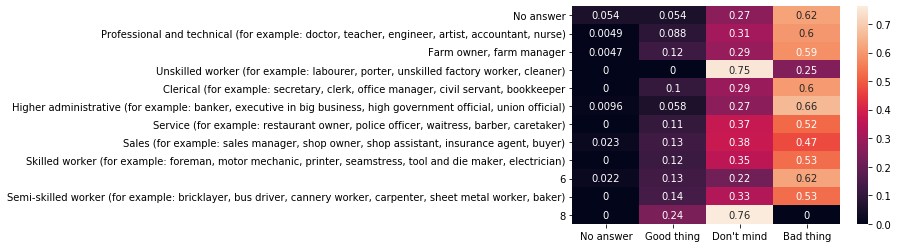

In [712]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

#percentage_map = 
sns.heatmap(test_mat, annot=True)

In [694]:
nr_columns = ['2', '3', '4', '5','0']
#",".join(answer_dict[a] for a in nr_columns)
text_columns = []
for a in nr_columns:
    if a in answer_dict.keys(): text_columns.append(answer_dict[a])
    
text_columns = ",".join(text_columns)

#a in answer_dict.keys()


'op_2,op_3,op_4,op_5'

In [686]:
answer_dict[2]

KeyError: 2

In [649]:
test_mat.div(test_mat.sum(axis=0), axis=1).style.format("{:.2%}")

,No answer,Better off,Worse off,Or about the same,Respondents
Don't know,9.38%,25.50%,25.82%,25.01%,3.78%
No answer,87.52%,15.01%,33.24%,23.85%,2.43%
Mentioned,0.00%,27.22%,23.44%,25.96%,2.58%
Not mentioned,3.10%,32.26%,17.50%,25.18%,91.22%


In [680]:
nr_columns = [2, 3, 4, 5]
list(map(lambda a : answer_dict[a],nr_columns))

KeyError: 2

In [401]:
res_df['Answers'] = res_df.sum(axis=1)
res_df.iloc[:,:-1] = res_df.iloc[:,:-1].div(res_df['Answers'], axis=0).round(3)

,Rather important,Very important,Not at all important,Not very important,No answer,Don't know,Answers
AUS,0.379,0.552,0.002,0.041,0.026,0.000,1813.0
IRQ,0.365,0.537,0.027,0.070,0.000,0.002,1200.0
JPN,0.506,0.404,0.009,0.068,0.011,0.002,1353.0
TWN,0.523,0.396,0.008,0.073,0.000,0.000,1223.0


In [468]:
response = {"question_nr" : question_nr, "theme" : theme, "subtheme" : subtheme, "headers" : res_dict['columns'], "countries" : res_dict['index'], "rows" : res_dict['data']}
json.dumps(response)

'{"question_nr": 2, "theme": "Important in life", "subtheme": " Friends", "headers": ["Rather important", "Very important", "Not at all important", "Not very important", "No answer", "Don\'t know", "Answers"], "countries": ["AUS", "IRQ", "JPN", "TWN"], "rows": [[0.379, 0.552, 0.002, 0.041, 0.026, 0.0, 1813.0], [0.365, 0.537, 0.027, 0.07, 0.0, 0.002, 1200.0], [0.506, 0.404, 0.009, 0.068, 0.011, 0.002, 1353.0], [0.523, 0.396, 0.008, 0.073, 0.0, 0.0, 1223.0]]}'

In [463]:
res_dict = res_df.iloc[:,:].to_dict(orient='split')
json.dumps(res_dict)

'{"index": ["AUS", "IRQ", "JPN", "TWN"], "columns": ["Rather important", "Very important", "Not at all important", "Not very important", "No answer", "Don\'t know", "Answers"], "data": [[0.379, 0.552, 0.002, 0.041, 0.026, 0.0, 1813.0], [0.365, 0.537, 0.027, 0.07, 0.0, 0.002, 1200.0], [0.506, 0.404, 0.009, 0.068, 0.011, 0.002, 1353.0], [0.523, 0.396, 0.008, 0.073, 0.0, 0.0, 1223.0]]}'

In [448]:
res_json.replace("Don't","Don't")

'{"headers":["Rather important","Very important","Not at all important","Not very important","No answer","Don\'t know","Answers"],"index":["AUS","IRQ","JPN","TWN"],"rows":[[0.379,0.552,0.002,0.041,0.026,0.0,1813.0],[0.365,0.537,0.027,0.07,0.0,0.002,1200.0],[0.506,0.404,0.009,0.068,0.011,0.002,1353.0],[0.523,0.396,0.008,0.073,0.0,0.0,1223.0]]}'

In [422]:
res_df.iloc[:,:]

,Very important,Not at all important,Not very important,No answer,Don't know,Answers
AUS,0.552,0.002,0.041,0.026,0.000,1813.0
IRQ,0.537,0.027,0.070,0.000,0.002,1200.0
JPN,0.404,0.009,0.068,0.011,0.002,1353.0
TWN,0.396,0.008,0.073,0.000,0.000,1223.0


In [371]:
print(question)
print(theme)
print(subtheme)
display(res_df)

2.0
Important in life
 Friends


,Rather important,Very important,Not at all important,Not very important,No answer,Don't know
AUS,687.0,1001.0,4.0,74.0,47.0,0.0
IRQ,438.0,644.0,32.0,84.0,0.0,2.0
JPN,684.0,547.0,12.0,92.0,15.0,3.0
TWN,640.0,484.0,10.0,89.0,0.0,0.0


In [336]:
res_df.iloc[:,:-1]

,Rather important,Very important,Not at all important,Not very important,No answer,Don't know
AUS,687.0,1001.0,4.0,74.0,47.0,0.0
IRQ,438.0,644.0,32.0,84.0,0.0,2.0
JPN,684.0,547.0,12.0,92.0,15.0,3.0
TWN,640.0,484.0,10.0,89.0,0.0,0.0


In [503]:
import re


country_alpha = ['AND','AUS','IRQ']
country_alpha = list_to_sql_string(country_alpha)

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

select_question_answers = f"""
            SELECT "B_COUNTRY_ALPHA","Q{question_nr}", COUNT("Q{question_nr}") FROM QUESTIONS WHERE "B_COUNTRY_ALPHA" IN ({country_alpha}) GROUP BY "B_COUNTRY_ALPHA","Q{question_nr}" ORDER BY "B_COUNTRY_ALPHA"
        """
        
results = PSQL_execute(select_question_answers)

nr_columns = list(set(map(lambda a : a[1],results)))
print(nr_columns)
nr_columns = sorted(nr_columns, key=natural_keys)
nr_columns = sorted(nr_columns)
print(nr_columns)





['-2', '2', '4', '3', '1', '-1']
['-1', '-2', '1', '2', '3', '4']


In [303]:
res_df.iloc[1][0:-1] = res_df.iloc[1][0:-1]/res_df.iloc[1][0:-1].sum()

Rather important        0.365000
Very important          0.536667
Not at all important    0.026667
Not very important      0.070000
No answer               0.000000
Don't know              0.001667
Name: IRQ, dtype: float64

In [478]:
res_df.style.format("{:.2%}")

,Rather important,Very important,Not at all important,Not very important,No answer,Don't know,Answers
AUS,37.90%,55.20%,0.20%,4.10%,2.60%,0.00%,181300.00%
IRQ,36.50%,53.70%,2.70%,7.00%,0.00%,0.20%,120000.00%
JPN,50.60%,40.40%,0.90%,6.80%,1.10%,0.20%,135300.00%
TWN,52.30%,39.60%,0.80%,7.30%,0.00%,0.00%,122300.00%


In [278]:
query = '''SELECT "B_COUNTRY_ALPHA" from questions GROUP BY "B_COUNTRY_ALPHA"'''
PSQL_execute(query)

[('ROU',),
 ('AUS',),
 ('TWN',),
 ('EGY',),
 ('CHN',),
 ('GRC',),
 ('CHL',),
 ('GTM',),
 ('ARG',),
 ('USA',),
 ('SRB',),
 ('MYS',),
 ('TJK',),
 ('NIC',),
 ('CAN',),
 ('BRA',),
 ('RUS',),
 ('MAC',),
 ('NGA',),
 ('BGD',),
 ('KAZ',),
 ('IRN',),
 ('MMR',),
 ('PAK',),
 ('KOR',),
 ('HKG',),
 ('ECU',),
 ('PER',),
 ('ZWE',),
 ('PRI',),
 ('KGZ',),
 ('VNM',),
 ('NZL',),
 ('LBN',),
 ('UKR',),
 ('THA',),
 ('JPN',),
 ('JOR',),
 ('PHL',),
 ('COL',),
 ('AND',),
 ('BOL',),
 ('MEX',),
 ('TUR',),
 ('DEU',),
 ('IDN',),
 ('CYP',),
 ('TUN',),
 ('IRQ',),
 ('ETH',),
 ('SGP',)]

In [250]:
resp_dict = {}
for i, response in enumerate(response_options):
    resp_dict[nr_columns[i]] = response
resp_dict

{'-2': 'No answer',
 '2': 'Rather important',
 '4': 'Not at all important',
 '3': 'Not very important',
 '1': 'Very important',
 '-1': "Don't know"}

In [135]:
query = 'SELECT * FROM world_fertility'
cursor = connection.cursor()
cursor.execute(query)
results = cursor.fetchall()

results[0]


InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


Connections can be used as context managers. Note that a context wraps a transaction: if the context exits with success the transaction is committed, if it exits with an exception the transaction is rolled back. Note that the connection is not closed by the context and it can be used for several contexts.

In [144]:
## Connection is used as a context manager, avoiding that a faulty query blocks the connection
with connection:
    with connection.cursor() as cursor:
        cursor.execute('SELECT * FROM world_fertility')
        results = cursor.fetchall()
results[0]

('Afghanistan', 4.5, 'AFG')

In [148]:
def PSQL_execute(query):
    with connection:
        with connection.cursor() as cursor:
            cursor.execute('SELECT * FROM world_fertility')
            results = cursor.fetchall()
    return results
    
    
query = 'SELECT * FROM world_fertility'
PSQL_execute(query)

[('Afghanistan', 4.5, 'AFG'),
 ('Albania', 1.6, 'ALB'),
 ('Algeria', 3.0, 'DZA'),
 ('Andorra', 1.3, 'AND'),
 ('Angola', 5.5, 'AGO'),
 ('Antigua and Barbuda', 2.0, 'ATG'),
 ('Argentina', 2.3, 'ARG'),
 ('Armenia', 1.8, 'ARM'),
 ('Aruba', 1.9, 'ABW'),
 ('Australia', 1.7, 'AUS'),
 ('Austria', 1.5, 'AUT'),
 ('Azerbaijan', 1.7, 'AZE'),
 ('Bahrain', 2.0, 'BHR'),
 ('Bangladesh', 2.0, 'BGD'),
 ('Barbados', 1.6, 'BRB'),
 ('Belarus', 1.4, 'BLR'),
 ('Belgium', 1.6, 'BEL'),
 ('Belize', 2.3, 'BLZ'),
 ('Benin', 4.8, 'BEN'),
 ('Bermuda', 1.6, 'BMU'),
 ('Bhutan', 2.0, 'BTN'),
 ('Bolivia', 2.7, 'BOL'),
 ('Bosnia and Herzegovina', 1.3, 'BIH'),
 ('Botswana', 2.9, 'BWA'),
 ('Brazil', 1.7, 'BRA'),
 ('Brunei', 1.8, 'BRN'),
 ('Bulgaria', 1.6, 'BGR'),
 ('Burkina Faso', 5.2, 'BFA'),
 ('Burundi', 5.4, 'BDI'),
 ('Cambodia', 2.5, 'KHM'),
 ('Cameroon', 4.6, 'CMR'),
 ('Canada', 1.5, 'CAN'),
 ('Cape Verde', 2.3, 'CPV'),
 ('Central African Republic', 4.7, 'CAF'),
 ('Chad', 5.7, 'TCD'),
 ('Chile', 1.6, 'CHL'),
 ('China